In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from nemo import evaluate_nemo
import util
from topology import get_lognorm_hist
import topology
from util import evaluate
import pandas as pd
import random
from nemo import NemoSolver

#### Topology Setup

In [2]:
seed = 4
np.random.seed(seed)

device_number = 1000
avg = 50
c_capacity = 50
max_resources = device_number * avg - c_capacity

X_dim_range = [0, 100]
Y_dim_range = [-50, 50]
centers = 40

H, bins = get_lognorm_hist()
coords_df = topology.coords_sim(device_number, centers, X_dim_range, Y_dim_range, seed)
coord_dict = {"sim(1000)": coords_df}

df_dict_topologies = topology.create_topologies_from_dict(coord_dict, H, max_resources, c_capacity,
                                                          weights=(1, avg * 2), dist="lognorm", with_clustering=True,
                                                          kmin=10, kmax=30, kseed=10)
c_coords = coords_df.iloc[0][["x", "y"]]

Creating df for sim(1000)
Optimal k is 21
Done


In [3]:
coords_df

,x,y,latency
0,71.925332,25.565323,0.000000
1,24.775013,11.958341,49.074459
2,5.770977,8.497964,68.320520
3,30.952786,-3.329505,50.136420
4,18.231240,4.925715,57.524334
...,...,...,...
996,88.052679,11.635696,21.310228
997,34.643330,-22.089226,60.505403
998,20.830278,17.439655,51.737134
999,36.871673,9.978153,38.362988


In [4]:
random.seed(seed)
items = range(1, coords_df.shape[0])
# Number of times to randomly select and remove elements
x = 10
# Number of elements to select and remove each time
n = 20
changed_nodes_dict = {}

# Perform the random selection and removal x times
for i in range(1, x + 1):
    if len(items) >= n:
        selected_elements = random.sample(items, n)
        changed_nodes_dict[i] = selected_elements
        items = [element for element in items if element not in selected_elements]
print(changed_nodes_dict)

{1: [242, 311, 106, 739, 406, 491, 159, 93, 69, 21, 412, 563, 940, 297, 820, 784, 61, 228, 533, 550], 2: [379, 292, 817, 183, 866, 114, 277, 226, 986, 970, 28, 868, 673, 846, 275, 839, 287, 205, 175, 328], 3: [317, 671, 926, 780, 913, 906, 939, 404, 94, 903, 649, 367, 717, 422, 545, 269, 193, 268, 510, 306], 4: [98, 890, 945, 600, 916, 335, 8, 991, 325, 626, 766, 962, 347, 924, 832, 559, 213, 457, 467, 654], 5: [326, 483, 505, 178, 258, 345, 290, 900, 883, 48, 89, 51, 517, 696, 316, 580, 596, 719, 526, 775], 6: [396, 163, 763, 221, 76, 473, 230, 723, 720, 504, 319, 208, 411, 499, 847, 670, 372, 722, 637, 224], 7: [384, 118, 978, 71, 824, 265, 331, 889, 681, 716, 278, 140, 392, 202, 346, 541, 30, 47, 424, 811], 8: [100, 352, 875, 804, 400, 20, 395, 355, 394, 180, 925, 778, 497, 743, 809, 975, 92, 360, 740, 231], 9: [553, 368, 164, 309, 476, 732, 191, 420, 699, 11, 455, 54, 566, 204, 456, 957, 982, 454, 365, 698], 10: [123, 564, 259, 544, 141, 74, 78, 68, 921, 210, 749, 849, 185, 761, 50

In [5]:
coord_list = [coords_df]

orig_df = coords_df.copy()
for i, node_ids in changed_nodes_dict.items():
    update_df = topology.coords_sim(device_number, centers, X_dim_range, Y_dim_range, with_latency=True,
                                    c_coords=c_coords)
    update_df = update_df.loc[node_ids]
    orig_df.loc[update_df.index] = update_df
    coord_list.append(orig_df.copy())

len(coord_list)

11

In [6]:
changed_nodes_dict.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [7]:
t_label = "sim(1000)"
prim_df, c_coords, base_col, slot_columns, centroids, opt_k, sil = df_dict_topologies[t_label]

eval_matrix = {}
prim_df

,x,y,latency,type,base,weight,capacity_100,capacity_90,capacity_80,capacity_70,capacity_60,capacity_50,capacity_40,capacity_30,capacity_20,capacity_10,capacity_5,capacity_1,cluster
0,71.925332,25.565323,0.000000,coordinator,9223372036854775807,0,50,50,50,50,50,50,50,50,50,50,50,50,-1
1,24.775013,11.958341,49.074459,worker,9223372036854775807,1,50,48,49,44,42,54,40,34,34,73,27,77,1
2,5.770977,8.497964,68.320520,worker,9223372036854775807,1,50,53,48,42,44,59,52,57,42,34,11,27,11
3,30.952786,-3.329505,50.136420,worker,9223372036854775807,1,50,49,54,44,47,43,37,58,28,38,27,8,1
4,18.231240,4.925715,57.524334,worker,9223372036854775807,27,50,49,55,44,48,58,51,35,33,17,14,0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,88.052679,11.635696,21.310228,worker,9223372036854775807,1,50,48,51,52,58,62,75,47,59,17,38,39,6
997,34.643330,-22.089226,60.505403,worker,9223372036854775807,1,50,52,50,47,50,48,40,48,28,27,30,119,16
998,20.830278,17.439655,51.737134,worker,9223372036854775807,1,50,49,47,57,53,57,66,38,26,99,94,154,11
999,36.871673,9.978153,38.362988,worker,9223372036854775807,12,50,50,49,53,40,54,33,38,44,79,59,4,19


In [220]:
coord_list[9]

,x,y,latency
0,71.925332,25.565323,0.000000
1,24.775013,11.958341,49.074459
2,5.770977,8.497964,68.320520
3,30.952786,-3.329505,50.136420
4,18.231240,4.925715,57.524334
...,...,...,...
996,88.052679,11.635696,21.310228
997,34.643330,-22.089226,60.505403
998,20.830278,17.439655,51.737134
999,36.871673,9.978153,38.362988


In [221]:
print("Required:", prim_df["weight"].sum(), "Available:", prim_df["capacity_100"].sum())
colors, light_colors, palette = util.get_color_list(opt_k)
palette

Required: 5971 Available: 50050


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)]

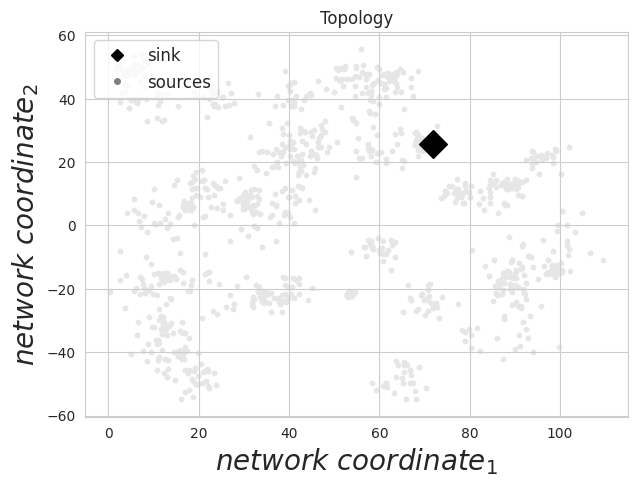

In [222]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))
ax1 = util.plot_topology(ax1, prim_df, scale_fac=0.1)

X_dim = ax1.get_xlim()
Y_dim = ax1.get_ylim()

# plt.savefig("plots/sim_1000/sim_" + str(device_number - 1) + "_ncs.svg", bbox_inches="tight")

plt.show()

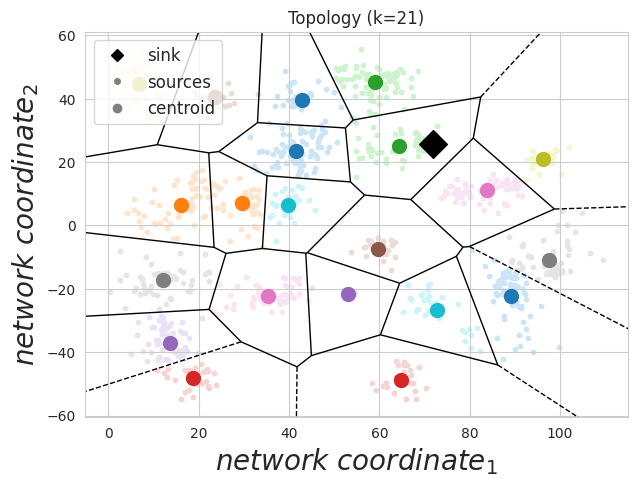

In [223]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))

ax1 = util.plot_topology(ax1, prim_df, colors=colors, title='Topology (k=' + str(opt_k) + ")", scale_fac=0.1,
                         plot_voronoi=True, plot_centroid=True)

ax1.set_xlim(X_dim)
ax1.set_ylim(Y_dim)

# plt.savefig("plots/sim_1000/sim_" + str(device_number - 1) + "_ncs_grouped.svg", bbox_inches="tight")

plt.show()

## Changing Topology

In [224]:
param_dict = {
    "weight_1": {"merge_factor": 0.1, "step_size": 0.3},
    "weight_2": {"merge_factor": 0.9, "step_size": 0.2},
    "weight": {"merge_factor": 0.4, "step_size": 0.4},
}

In [225]:
# for the plots and vanilla NEMO
eval_name = "nemo_dc"
slot_col = "capacity_100"
weight_col = "weight"

df_dict, opt_dict, limits_dict = evaluate_nemo(prim_df, [slot_col], weight_col,
                                               merge_factor=param_dict[weight_col][
                                                   "merge_factor"],
                                               step_size=param_dict[weight_col]["step_size"],
                                               with_eval=False)
placement_df = df_dict[slot_col]

Starting nemo for: c=capacity_100, w=weight, l=20, step_size=0.4, merge_factor=0.4
Level 0 CH number:  1000
--------Balancing load for 21 clusters to 0
Clusters processed: 0
Clusters processed: 10
Clusters processed: 20
Level 1 CH number:  132
--------Balancing load for 8 clusters to 0
Clusters processed: 0
Level 2 CH number:  30
--------Balancing load for 3 clusters to 0
Clusters processed: 0
Level 3 CH number:  6


In [226]:
placement_df

,oindex,x,y,type,cluster,total_weight,unbalanced_weight,used_weight,total_capacity,free_capacity,level,parent
0,0,71.925332,25.565323,coordinator,-1,<NA>,<NA>,<NA>,50,41,3,<NA>
1,1,24.775013,11.958341,worker,1,1,0,1,50,50,0,84
2,2,5.770977,8.497964,worker,11,1,0,1,50,50,0,896
3,3,30.952786,-3.329505,worker,1,1,0,1,50,50,0,401
4,4,18.231240,4.925715,worker,11,27,0,27,50,50,0,757
...,...,...,...,...,...,...,...,...,...,...,...,...
1075,997,34.643330,-22.089226,worker,16,1,0,1,50,50,0,64
1076,998,20.830278,17.439655,worker,11,1,0,1,50,50,0,999
1077,999,36.871673,9.978153,worker,19,12,0,9,50,19,1,84
1078,999,36.871673,9.978153,worker,19,12,0,3,50,19,1,623


In [227]:
evaluations = []
for coords_df in coord_list:
    update_df = coords_df[["x", "y"]]
    df = util.update_coordinates(placement_df, update_df)

    edf = evaluate(df)
    evaluations.append(edf)

In [228]:
evaluations[0]

,latency_distribution,received_packets
0,0.000000,9.0
780,6.805741,49.0
620,7.063575,48.0
886,8.082159,50.0
964,13.842273,22.0
...,...,...
373,50.651489,0.0
374,47.997970,0.0
375,58.872589,0.0
376,29.893998,0.0


## Evaluation

#### Latency

In [229]:
eval_colors = {
    "dt": colors[0],
    "leach": colors[1],
    "mst": colors[2],
    "chain": colors[3],
    "nemo": colors[4],
    "nemo_base": colors[4],
    "nemo_dc_base": colors[4],
    "NEMO_base": colors[4],
    "nemo_rc": colors[5],
    "nemo_rc_base": colors[5],
    "nemo (rdm groups)_base": colors[5],
    "nemo_dc": colors[6],
    "NEMO+redistribution": colors[6],
    "nemo_pen": colors[7],
    "nemo_pen_base": colors[8],
    "nemo_dc_weight_2": colors[9],
    "nemo_dc_weight": colors[10]
}

renaming_dict = {
    "nemo_dc": "nemo (w=1,",
    "nemo_dc_weight_2": "nemo (w=2,",
    "nemo_dc_weight": "nemo (w=ln[1, 50],",
}


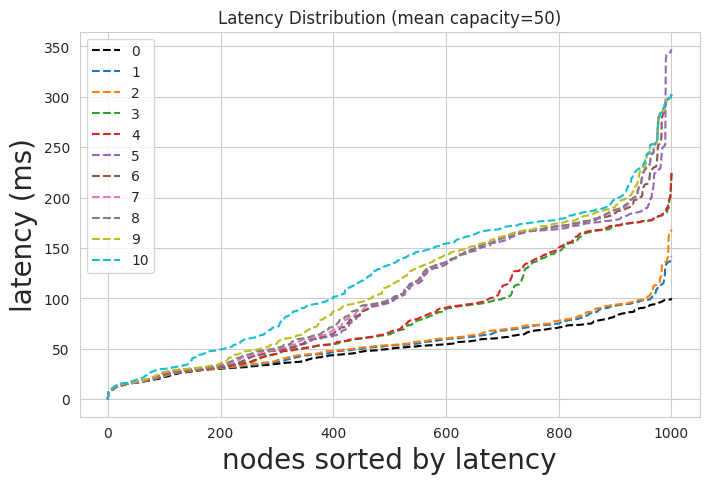

Means:  {'0': 50.54, '1': 54.85, '2': 56.3, '3': 83.31, '4': 84.79, '5': 103.96, '6': 106.12, '7': 107.81, '8': 108.65, '9': 113.16, '10': 123.7}
Quantiles:  {'0': 82.86, '1': 92.73, '2': 93.89, '3': 171.93, '4': 172.35, '5': 177.97, '6': 184.46, '7': 187.48, '8': 187.96, '9': 190.71, '10': 197.9}


In [230]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), sharey="all")
quant_dict = {}
mean_dict = {}

for i, df in enumerate(evaluations):
    l = str(i)
    sv = df["latency_distribution"].sort_values()

    quant_dict[l] = round(sv.quantile(0.9), 2)
    mean_dict[l] = round(sv.mean(), 2)
    if i == 0:
        sv.plot(ax=ax1, use_index=False, label=l, linestyle="--", color="black")
    else:
        sv.plot(ax=ax1, use_index=False, label=l, linestyle="--")

ax1.set_xlabel('nodes sorted by latency')
ax1.set_ylabel('latency (ms)')

ax1.legend(loc="upper left", prop={'size': 10})
# Display a figure.
# plt.ylim([0, 100])

ax1.yaxis.label.set_size(20)
ax1.xaxis.label.set_size(20)

# plt.savefig("plots/sim_1000/eval_latency.svg")

ax1.set_title('Latency Distribution (mean capacity=' + str(avg) + ")")
plt.show()
print("Means: ", mean_dict)
print("Quantiles: ", quant_dict)

## Test Reoptimization

In [237]:
i = 0
max_i = 1
ndf = prim_df.copy()
ndf["x"] = coord_list[i]["x"]
ndf["y"] = coord_list[i]["y"]

nemo = NemoSolver(ndf, slot_col, weight_col, max_levels=50, step_size=param_dict[weight_col]["step_size"],
                  merge_factor=param_dict[weight_col]["merge_factor"])
df, opts, limits = nemo.nemo_full()

edf = util.evaluate(df)
evaluations[i] = edf
edf

Level 0 CH number:  1000
--------Balancing load for 21 clusters to 0
Clusters processed: 0
Clusters processed: 10
Clusters processed: 20
Level 1 CH number:  132
--------Balancing load for 8 clusters to 0
Clusters processed: 0
524 980 [(980, 2)] {64, 524, 685, 719, 49, 882, 821}
49 980 [(980, 1)] {64, 685, 719, 49, 882, 821}
54 666 [(666, 7)] {64, 937, 957, 592, 755, 54, 125}
64 666 [(666, 9), (980, 12)] {64, 937, 957, 592, 755, 125}
64 980 [(666, 9), (980, 12)] {64, 685, 719, 882, 821}
585 49 [(49, 4)] {644, 969, 585, 619, 880, 626, 409, 603, 989, 862, 895}
603 49 [(49, 1)] {644, 969, 619, 880, 626, 409, 603, 989, 862, 895}
619 49 [(49, 2)] {644, 969, 619, 880, 626, 409, 989, 862, 895}
125 666 [(666, 3)] {937, 957, 592, 755, 125}
685 980 [(980, 2)] {685, 719, 882, 821}
719 980 [(980, 1)] {719, 882, 821}
747 880 [(880, 2)] {674, 325, 934, 678, 330, 426, 747, 365, 496, 658, 948, 440, 441, 795, 767}
767 880 [(880, 3)] {674, 325, 934, 678, 330, 426, 365, 496, 658, 948, 440, 441, 795, 767}


,latency_distribution,received_packets
0,0.000000,9.0
780,6.805741,49.0
620,7.063575,48.0
886,8.082159,50.0
964,13.842273,22.0
...,...,...
373,50.651489,0.0
374,47.997970,0.0
375,58.872589,0.0
376,29.893998,0.0


In [238]:
removed = set()

for i, nodes in changed_nodes_dict.items():
    for node_idx in nodes:
        print("processing node", i, node_idx)
        if node_idx in removed:
            continue
        else:
            removed.add(node_idx)
            
        df_re, opt_dict, resource_limit, level = nemo.remove_node(node_idx)
        node = prim_df.iloc[node_idx].to_dict()
        node["x"] = coord_list[i].iloc[node_idx]["x"]
        node["y"] = coord_list[i].iloc[node_idx]["y"]
        node["capacity"] = node[slot_col]
        node["weight"] = node[weight_col]
        node_idx, df_placement, resource_limit = nemo.add_node(node)
        if resource_limit:
            print("Overloaded!!!!!!!!!!!!!!!!")
    edf = evaluate(df_re)
    evaluations[i] = edf.copy()

processing node 1 242
242 662 [(662, 1)] {37, 848, 242, 381, 566, 186, 124, 701, 831}
processing node 1 311
311 320 [(320, 20)] {257, 641, 193, 778, 142, 311, 728, 90}
processing node 1 106
106 528 [(528, 1)] {835, 291, 293, 5, 231, 712, 613, 106, 364, 660, 213, 88, 825, 445, 286, 991}
processing node 1 739
739 629 [(629, 3)] {130, 739, 209, 17, 274, 853, 26, 59, 60, 94}
processing node 1 406
406 886 [(886, 21), (344, 31)] {954, 754, 116, 406}
406 344 [(886, 21), (344, 31)] {519, 429, 433, 466, 406, 123}
388 406 [(406, 1)] {388, 264, 107, 108, 401, 694, 959}
264 406 [(406, 2)] {264, 107, 108, 401, 694, 959}
107 406 [(406, 1)] {107, 108, 401, 694, 959}
108 406 [(406, 4)] {108, 401, 694, 959}
401 406 [(406, 4)] {401, 694, 959}
694 406 [(406, 13), (754, 44)] {694, 959}
959 406 [(406, 1)] {959}
Level 1 CH number:  7
--------Balancing load for 1 clusters to 0
Clusters processed: 0
694 754 [(754, 44)] {126, 684, 694}
Level 2 CH number:  2
--------Balancing load for 1 clusters to 0
Clusters p

KeyError: 886

In [233]:
df_re

,oindex,x,y,type,cluster,total_weight,unbalanced_weight,used_weight,total_capacity,free_capacity,level,parent,load
0,0,71.925332,25.565323,coordinator,-1,<NA>,<NA>,<NA>,50,-117,4,<NA>,167
1,1,24.775013,11.958341,worker,1,1,0,1,50,50,0,84,0
2,2,5.770977,8.497964,worker,11,1,0,1,50,50,0,896,0
3,3,30.952786,-3.329505,worker,1,1,0,1,50,0,1,174,50
4,4,18.231240,4.925715,worker,11,27,0,27,50,50,0,757,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,1036,62.469605,5.578308,worker,15,3,0,3,50,50,0,178,0
1092,1037,90.044408,-47.363263,worker,0,1,0,1,50,50,0,368,0
1093,1038,11.242860,-23.550342,worker,7,1,0,1,50,50,0,973,0
1094,1039,2.839977,28.039618,worker,8,1,0,1,50,50,0,278,0


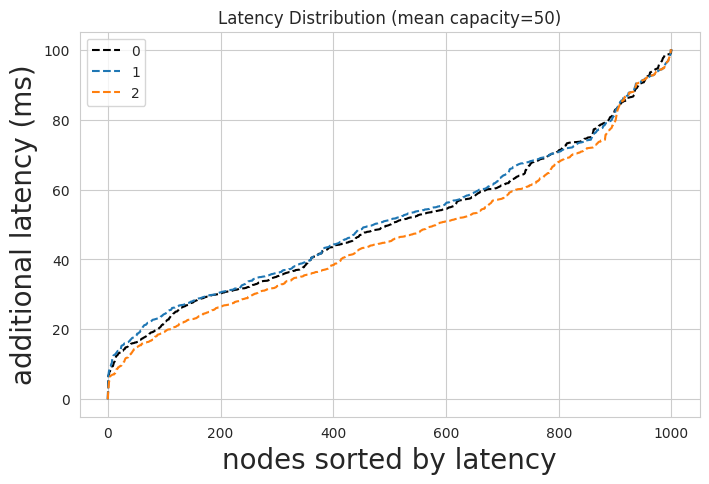

Means:  {'0': 50.54, '1': 51.35, '2': 46.98}
Quantiles:  {'0': 82.86, '1': 81.55, '2': 79.36}


In [234]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), sharey="all")
quant_dict = {}
mean_dict = {}

for i, df in enumerate(evaluations):
    if i > 2:
        break
    l = str(i)
    sv = df["latency_distribution"].sort_values()

    quant_dict[l] = round(sv.quantile(0.9), 2)
    mean_dict[l] = round(sv.mean(), 2)
    if i == 0:
        sv.plot(ax=ax1, use_index=False, label=l, linestyle="--", color="black")
    else:
        sv.plot(ax=ax1, use_index=False, label=l, linestyle="--")

ax1.set_xlabel('nodes sorted by latency')
ax1.set_ylabel('additional latency (ms)')

ax1.legend(loc="upper left", prop={'size': 10})
# Display a figure.
# plt.ylim([0, 100])

ax1.yaxis.label.set_size(20)
ax1.xaxis.label.set_size(20)

# plt.savefig("plots/sim_1000/eval_latency.svg")

ax1.set_title('Latency Distribution (mean capacity=' + str(avg) + ")")
plt.show()
print("Means: ", mean_dict)
print("Quantiles: ", quant_dict)

In [ ]:
# TODO add insertion of nodes, check scalability test with different weights